# Advertising

In [40]:
import os
from utils.paths import get_data_path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

## 1) 데이터 로딩 & 시각화
- 단위 당 1000달러

In [16]:
CSV_path = get_data_path("advertising.csv")
df = pd.read_csv(CSV_path)
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,15.1305,5.283892,1.6,11.000,16.00,19.050,27.0


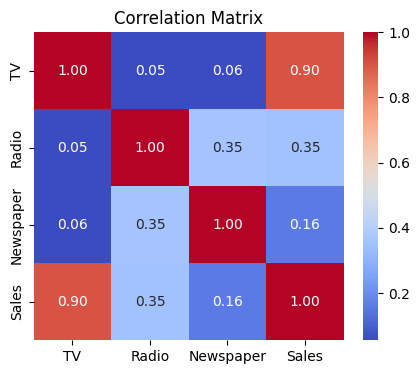

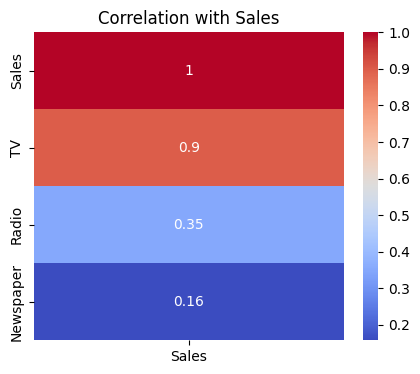

In [17]:
# 상관 히트맵
plt.figure(figsize=(5,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#target과 변수간의 상관관계 시각화
corr = df.corr(numeric_only=True)
plt.figure(figsize=(5, 4))
sns.heatmap(corr[['Sales']].sort_values(by='Sales', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlation with Sales')
plt.show()

- 상관관계 분석 시 target과 강한 상관관계를 보이는 변수는 TV가 유일
- target값을 제외하고 다른 변수들 간의 상관관계 역시 특별한 관계는 보이지는 않음

## 2) 단순선형회귀-statsmodels

In [19]:
#statsmodels
X = sm.add_constant(df["TV"])
y = df["Sales"]
ols_tv = sm.OLS(y, X).fit()
ols_tv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     856.2
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           7.93e-74
Time:                        10:00:31   Log-Likelihood:                -448.99
No. Observations:                 200   AIC:                             902.0
Df Residuals:                     198   BIC:                             908.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9748      0.323     21.624      0.000       6.339       7.611
TV             0.0555      0.002     29.260      0.000       0.052       0.059
==============================================================================
Omnibus:                        0.013   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.993   Jarque-Bera (JB):                0.043
Skew:                          -0.018   Prob(JB):                        0.979
Kurtosis:                       2.938   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2) 단순선형회귀-sklearn

In [22]:
#sklearn
X = df[["TV"]]
y = df["Sales"]

lr_tv = LinearRegression().fit(X, y)
pred_tv = lr_tv.predict(X)

print("coef_", lr_tv.coef_, "intercept_", lr_tv.intercept_)
print("R^2:", r2_score(y, pred_tv))
print("RMSE:", np.sqrt(mean_squared_error(y, pred_tv)))

coef_ [0.05546477] intercept_ 6.974821488229891
R^2: 0.8121757029987414
RMSE: 2.2842381438447106


- 결정계수 값 약 0.812으로 TV 광고비가 매출변동의 81.2%를 설명
- p-value가 7.927912e-74로 tv광고가 매출에 영향을 준다는 것이 사실상 확신 수준이다. 

## 3) 다중선형회귀

In [62]:
X = df[["TV","Radio","Newspaper"]]
y = df["Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression().fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

def report(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f} | R^2: {r2:.3f}")

report(y_train, y_train_pred, "Train")
report(y_test,  y_test_pred, "Test")

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

Train -> RMSE: 1.636 | R^2: 0.900
Test -> RMSE: 1.705 | R^2: 0.906
Coefficients: [0.05450927 0.10094536 0.00433665]
Intercept: 4.714126402214127


- y_train, y_test 각각 rmse의 오차가 적기 때문에 과적합 위험은 낮음
- 결정계수 0.9 수준으로 모델의 설명력 우수함
- coef가 순서대로 0.05, 0.1, 0.0043으로 가장 효과가 큰 매체는 Radio이고 신문 같은 경우는 0.0043으로 상대적으로 굉장히 미비함

## 3) 다중선형회귀-newspaper 제외 & Lasso와 비교
- 가장 효과가 저조한 신문을 제거할 시 성능이 좋아질까? 확인

In [64]:
X2 = df[["TV","Radio"]]
y2 = df["Sales"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

lr2 = LinearRegression().fit(X2_train, y2_train)

y2_train_pred = lr2.predict(X2_train)
y2_test_pred = lr2.predict(X2_test)

def report(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f} | R^2: {r2:.3f}")

report(y2_train, y2_train_pred, "Train")
report(y2_test,  y2_test_pred, "Test")

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_,"\n")

lasso = Lasso(alpha=0.1)  # 규제 강도 alpha
lasso.fit(X_train, y_train)

print("Lasso Feature:", lasso.feature_names_in_)
print("Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)

Train -> RMSE: 1.638 | R^2: 0.900
Test -> RMSE: 1.687 | R^2: 0.908
Coefficients: [0.05450927 0.10094536 0.00433665]
Intercept: 4.714126402214127 

Lasso Feature: ['TV' 'Radio' 'Newspaper']
Coefficients: [0.05449934 0.10056182 0.00420248]
Intercept: 4.728408161116624


- 눈의 띄는 차이는 없음, 더 많은 변수를 포함하는 모델에서 확인해봐야할 듯
- Lasso를 한다고 newspaper 변수가 삭제되지는 않음

## 4) 잔차 체크

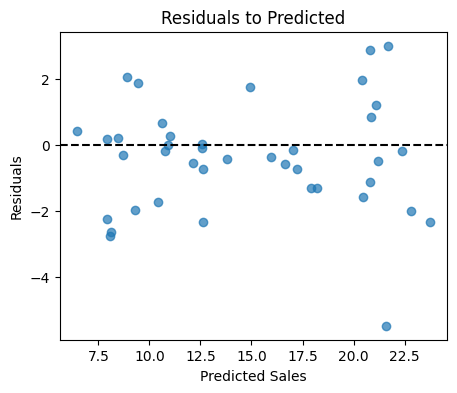

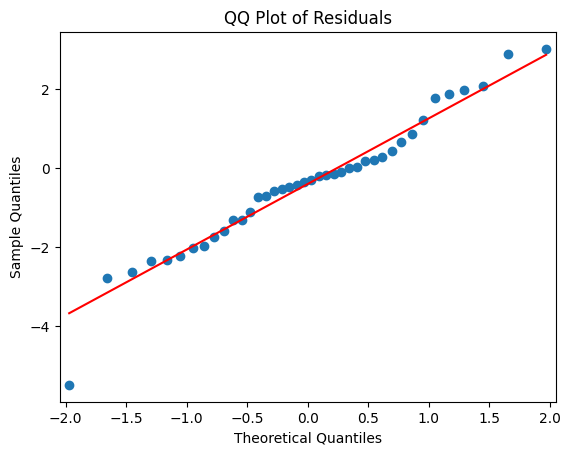

In [65]:
# residuals to predicted
residuals = y_test - y_test_pred
plt.figure(figsize=(5,4))
plt.scatter(y_test_pred, residuals, alpha=0.7)
plt.axhline(0, ls="--", c="k")
plt.xlabel("Predicted Sales"); plt.ylabel("Residuals")
plt.title("Residuals to Predicted")
plt.show()

# QQ-plot
sm.qqplot(residuals, line="s")
plt.title("QQ Plot of Residuals")
plt.show()


- residuals to predicted plot을 보면 0을 기준으로 흩어져있음, 하지만 양 끝단으로 갈수록 퍼지는 패턴의 모양은 부정적
- QQplot을 확인 시 정규성을 나타내는 선을 중심으로 잔차가 고루 분포됨. 정규성을 만족하고 있다고 보여짐

## 5) 다중공산성 확인

In [67]:
#다중공산성 확인
X_vif = sm.add_constant(X)
vif = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif


,feature,VIF
0,const,6.848900
1,TV,1.004611
2,Radio,1.144952
3,Newspaper,1.145187


- VIF가 세 변수 1에 위치하고 있기 때문에 다중공산성은 배제 가능하다고 보임

## 6) ROI 비교 - coef / avg_cost

TV           147.0425
Radio         23.2640
Newspaper     30.5540
dtype: float64 

TV           0.054509
Radio        0.100945
Newspaper    0.004337
dtype: float64 

TV           0.370704
Radio        4.339123
Newspaper    0.141934
dtype: float64 



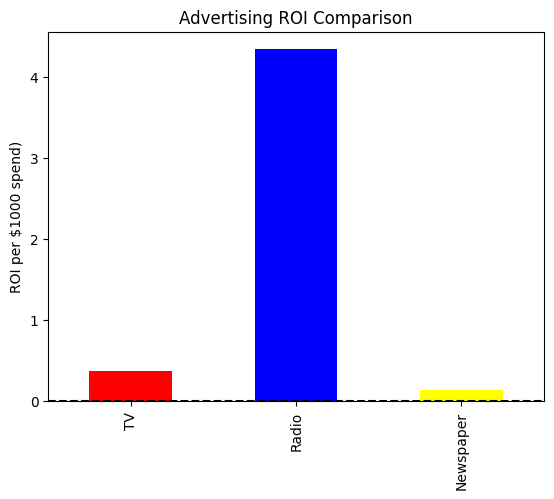

In [85]:
coefs = pd.Series(lr.coef_, index=X.columns)
avg_cost = X.mean()
roi = coefs / (avg_cost/1000)

print(avg_cost,"\n")
print(coefs,"\n")
print(roi,"\n")

# ROI 시각화
roi.plot(kind="bar", color=["red", "blue", "yellow"])
plt.ylabel("ROI per $1000 spend)")
plt.title("Advertising ROI Comparison")
plt.axhline(0, color="black", linestyle="--")
plt.show()

- ROI로 따지면 라디오가 압도적, 하지만 현실적으로 체감을 하기에는 기업은 라디오보단 TV 광고에 더 투자를 많이 함.

- 데이터의 구체적인 수집 연도는 명시가 안돼있고, 모의데이터라고 함

- 하지만 제작 단가가, 영상이 음성콘텐츠 때문에 비싸고 TV가 Radio보다 노출도가 높기 때문에 ROI가 낮음에도 불구하고 브랜드 인지도 OR 이미지 구축을 위해 주를 이룰 수도 있다고 생각